# Tutorial: Linear Regression - Case of air quality analysis.
Part 2. Simple multifactorial linear regression

In the previous part of this tutorial, we cleaned the data file from the measuring station. A new, completed measurement data file has been created, which we will now open.


We will now continue to prepare data for further analysis. One of the most important variables describing in linear regression is time. Most artificial and natural phenomena operate in hourly, daily and monthly cycles.

In [1]:
import pandas as pd
df = pd.read_csv('c:/TF/AirQ_filled.csv')
df.head(3)

,Unnamed: 0,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502


## Step 1. Launching the time variable
<span style="color:darkblue">We check what the date format is</span>

In [2]:
df[['Date','Time']].dtypes

Date    object
Time    object
dtype: object

There is no date format in dataframe. Link columns containing time.

In [3]:
df['DATE'] = df['Date']+' '+df['Time']
df['DATE'].head()

0    10/03/2004 18.00.00
1    10/03/2004 19.00.00
2    10/03/2004 20.00.00
3    10/03/2004 21.00.00
4    10/03/2004 22.00.00
Name: DATE, dtype: object

We create a new column containing the date and time. Then we convert the object format to the date format.

In [4]:
df['DATE'] = pd.to_datetime(df.DATE, format='%d/%m/%Y %H.%M.%S')
df.dtypes

Unnamed: 0                int64
Date                     object
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
DATE             datetime64[ns]
dtype: object

# Step 2. We add more columns based on the time variable

In industry, the day of the week is very important, so in such models it is worth adding a column with the number of the day.

In [5]:
df['Month'] = df['DATE'].dt.month
df['Weekday'] = df['DATE'].dt.weekday
df['Weekday_name'] = df['DATE'].dt.weekday_name
df['Hours'] = df['DATE'].dt.hour

In [6]:
df[['DATE','Month','Weekday','Weekday_name','Hours']].sample(3)

,DATE,Month,Weekday,Weekday_name,Hours
6109,2004-11-20 07:00:00,11,5,Saturday,7
3537,2004-08-05 03:00:00,8,3,Thursday,3
8053,2005-02-09 07:00:00,2,2,Wednesday,7


#### Graficzna analiza zanieczyszczenia według zmiennych czasowych

In [7]:
df.pivot_table(index='Weekday_name', values='CO(GT)', aggfunc='mean').plot(kind='bar')

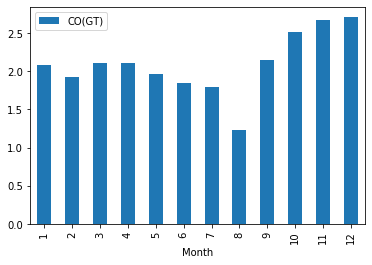

In [8]:
df.pivot_table(index='Month', values='CO(GT)', aggfunc='mean').plot(kind='bar')

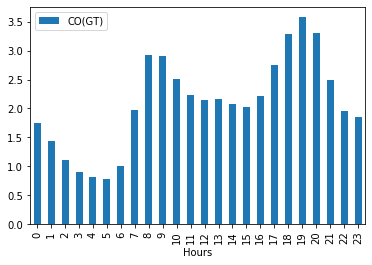

In [9]:
df.pivot_table(index='Hours', values='CO(GT)', aggfunc='mean').plot(kind='bar')

# Step 3. Correlation analysis
we set the result variable as:

#### CO(GT)   -   actual hourly average CO concentration in mg / m^3 (reference analyzer)

In [10]:
del df['Unnamed: 0']

In [11]:
CORREL = df.corr()
PKP = CORREL['CO(GT)'].to_frame().sort_values('CO(GT)')
PKP

,CO(GT)
PT08.S3(NOx),-0.715683
Weekday,-0.140231
RH,0.020122
AH,0.025227
T,0.025639
Month,0.112291
Hours,0.344071
PT08.S4(NO2),0.631854
NO2(GT),0.682774
NOx(GT),0.773677


Text(0, 0.5, 'Continuous independent variables')

<Figure size 720x576 with 0 Axes>

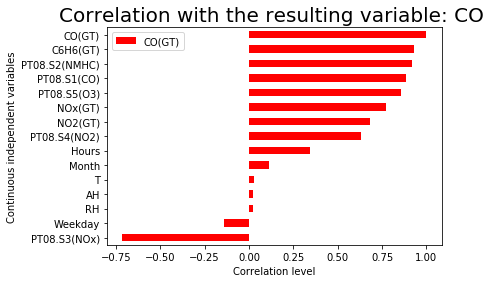

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
PKP.plot(kind='barh', color='red')
plt.title('Correlation with the resulting variable: CO ', fontsize=20)
plt.xlabel('Correlation level')
plt.ylabel('Continuous independent variables')

Variables based on time are not very well correlated with the described variable: CO (GT).
The temptation arises to use better, better correlated independent variables for the model. The problem is that these variables can be part of the result. So if there is pollution then all substances are in the air.

Our task is to examine how weather and time affect the level of pollution. We'll cover this task in the next part of the tutorial.

## Step 4. We are now checking shift 

for independent variables with low direct correlation.
How does weather affect CO2 levels?

### <span style="color:#1155cc">Variable RH - Relative humidity (%)</span>
We check a variable with very low correlation with the resulting CO (GT) variable

In [13]:
def cross_corr(x, y, lag=0):
    return x.corr(y.shift(lag))

def shift_Factor(x,y,R):
    x_corr = [cross_corr(x, y, lag=i) for i in range(R)]
    
    # R factor is the number of the shifts who should be checked by the function
    Kot = pd.DataFrame(list(x_corr)).reset_index()
    Kot.rename(columns={0:'Corr', 'index':'Shift_num'}, inplace=True)
    
    # We find optimal correlation shift
    Kot['abs'] = Kot['Corr'].abs()
    SF = Kot.loc[Kot['abs']==Kot['abs'].max(), 'Shift_num']
    p1 = SF.to_frame()
    SF = p1.Shift_num.max()
    
    return SF

In [14]:
x = df.RH       # independent variable
y = df['CO(GT)']    # dependent variable
R = 20           # number of shifts who will be checked

In [15]:
SKO = shift_Factor(x,y,R)
print('Optimal shift for RH: ',SKO)

Optimal shift for RH:  12


In [16]:
cross_corr(x, y, lag=SKO)

0.39204313671898056

### <span style="color:#1155cc">Variable AH - Absolute humidity</span>

We check a variable with very low correlation with the resulting CO (GT) variable

In [17]:
x = df.AH       # independent variable
SKP = shift_Factor(x,y,R)
print('Optimal shift for AH: ',SKP)

Optimal shift for AH:  12


In [18]:
cross_corr(x, y, lag=SKP)

0.043756364102677595

Absolute humidity AH does not correlate with the variable CO (GT) so we eliminate it from the model

### <span style="color:#1155cc">Variable: Temperature in ° C</span>
We check a variable with very low correlation with the resulting CO (GT) variable.

In [19]:
x = df['T']      # independent variable
PKP = shift_Factor(x,y,R)
print('Optimal shift for T: ',PKP)

Optimal shift for T:  12


In [20]:
cross_corr(x, y, lag=PKP)

-0.22446569561762522

### <span style="color:#1155cc">We are now creating a new DataFrame with a 12-hour shift</span>
It turns out that temperature and humidity only correlate after 12 hours from the time the CO contamination changes.
Data shift creation function.

In [21]:
def df_shif(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for h in df.columns:
        if h == target:
            new[h] = df[target]
        else:
            new[h] = df[h].shift(periods=lag)
    return  pd.DataFrame(data=new)

Our goal is to create a multiple regression model:

    - Independent variables are: Temperature (T) and Relative humidity RH (%)
    - The dependent variable is the level of CO (GT)
    

In [22]:
df2 = df[['DATE', 'CO(GT)','RH', 'T']]

Adds a date and time to record temperature and humidity.

In [23]:
df2['weather_time'] = df2['DATE']

C:\ProgramData\Anaconda3\envs\OLD_TF\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df2.head(3)

,DATE,CO(GT),RH,T,weather_time
0,2004-03-10 18:00:00,2.6,48.9,13.6,2004-03-10 18:00:00
1,2004-03-10 19:00:00,2.0,47.7,13.3,2004-03-10 19:00:00
2,2004-03-10 20:00:00,2.2,54.0,11.9,2004-03-10 20:00:00


In [25]:
df3 = df_shif(df2, 'weather_time', lag=12)
df3.rename(columns={'weather_time':'Shift_weather_time'}, inplace=True) 
df3.head(13)

,DATE,CO(GT),RH,T,Shift_weather_time
0,NaT,NaN,NaN,NaN,2004-03-10 18:00:00
1,NaT,NaN,NaN,NaN,2004-03-10 19:00:00
2,NaT,NaN,NaN,NaN,2004-03-10 20:00:00
3,NaT,NaN,NaN,NaN,2004-03-10 21:00:00
4,NaT,NaN,NaN,NaN,2004-03-10 22:00:00
5,NaT,NaN,NaN,NaN,2004-03-10 23:00:00
6,NaT,NaN,NaN,NaN,2004-03-11 00:00:00
7,NaT,NaN,NaN,NaN,2004-03-11 01:00:00
8,NaT,NaN,NaN,NaN,2004-03-11 02:00:00
9,NaT,NaN,NaN,NaN,2004-03-11 03:00:00


In [26]:
df4 = df_shif(df3, 'RH', lag=12)
df4.rename(columns={'RH':'Shift_RH'}, inplace=True) 

In [27]:
df5 = df_shif(df4, 'T', lag=12)
df5.rename(columns={'T':'Shift_T'}, inplace=True) 

Deletes rows with incomplete data.

In [28]:
df5 = df5.dropna(how ='any')

In [29]:
df5.head()

,DATE,CO(GT),Shift_RH,Shift_T,Shift_weather_time
36,2004-03-10 18:00:00,2.6,58.1,10.5,2004-03-11 06:00:00
37,2004-03-10 19:00:00,2.0,59.6,10.2,2004-03-11 07:00:00
38,2004-03-10 20:00:00,2.2,57.4,10.8,2004-03-11 08:00:00
39,2004-03-10 21:00:00,2.2,60.6,10.5,2004-03-11 09:00:00
40,2004-03-10 22:00:00,1.6,58.4,10.8,2004-03-11 10:00:00


The table can be understood as meaning that a specific temperature at 6:00 gives a specific concentration of carbon monoxide at 18:00.

### Graphical analysis of relationships - Humidity and temperature to carbon monoxide
It looks rather poor

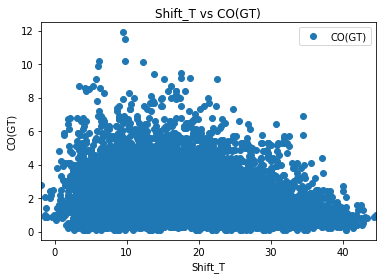

In [30]:
import matplotlib.pyplot as plt

df5.plot(x='Shift_T', y='CO(GT)', style='o')  
plt.title('Shift_T vs CO(GT)')  
plt.xlabel('Shift_T')  
plt.ylabel('CO(GT)')  
plt.show()

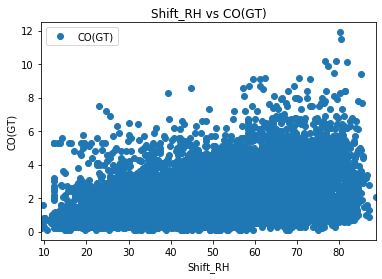

In [31]:
df5.plot(x='Shift_RH', y='CO(GT)', style='o')  
plt.title('Shift_RH vs CO(GT)')  
plt.xlabel('Shift_RH')  
plt.ylabel('CO(GT)')  
plt.show()

## Step 5. Building a multiple linear regression model in Sklearn

Declares X, y variables into the model.

In [32]:
X = df5[['Shift_RH', 'Shift_T']].values
y = df5['CO(GT)'].values

I divide the collection into training variables and test variables.

In [33]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

I am building a regression model.

In [34]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
import numpy as np

y_pred = regressor.predict(X_test)
y_pred = np.round(y_pred, decimals=2)

Comparison of variables from the model with real variables.

In [36]:
dfKK = pd.DataFrame({'CO(GT) Actual': y_test, 'CO(GT)_Predicted': y_pred})
dfKK.head(5)

,CO(GT) Actual,CO(GT)_Predicted
0,0.5,1.63
1,1.9,1.91
2,3.4,2.40
3,1.2,1.45
4,2.4,2.40


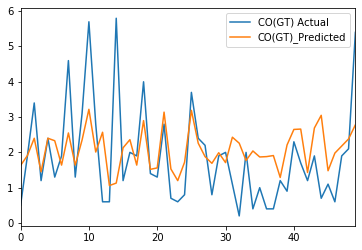

In [37]:
from sklearn import metrics

dfKK.head(50).plot()

In [38]:
from sklearn import metrics

print('Mean Absolute Error:    ', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:     ', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:     1.0011099195710456
Mean Squared Error:      1.779567238605898
Root Mean Squared Error: 1.3340042123643756


In [39]:
print('Mean Squared Error:     ', metrics.r2_score(y_test, y_pred))

Mean Squared Error:      0.15437562015505324


Carbon monoxide contamination cannot be predicted based on humidity and temperature.
In the next part, we will continue the analysis and preparation of data for linear regression.
Zapiszmy dane z nowymi kolumnami zmiennych opartych na czasie.

In [41]:
df.to_csv('c:/TF/AirQ_filled2.csv')
df = pd.read_csv('c:/TF/AirQ_filled2.csv')
df.head(3)

,Unnamed: 0,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DATE,Month,Weekday,Weekday_name,Hours
0,0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,3,2,Wednesday,18
1,1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,3,2,Wednesday,19
2,2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,3,2,Wednesday,20
